In [1]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np
import random as rn


from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

%matplotlib inline
import itertools

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU,Conv3D, MaxPooling3D
from keras.utils import to_categorical,plot_model
from keras.models import Sequential
from keras.optimizers import Adam


Using TensorFlow backend.


In [2]:
#for reproducibility in Python,numpy and Tensorflow we set their respective seeds as follows
os.environ['PYTHONHASHSEED']='0'
np.random.seed(1)
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread (this is recommended because it might be a cause of randomness)
sess=tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)

In [3]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

runs = ['306459','306138','306139']

data_sample0= np.empty([0,72,84])
for run in runs:
    input_file=h5py.File(data_folder+'/'+'HCAL_digi+rechit_occ_run'+run+'.hdf5','r+')
    data_sample0 = np.concatenate((data_sample0,np.array(input_file[group])),axis=0)

data_sample0=data_sample0[:,:,26:58]

average_occ = np.average(data_sample0)

for i in range(data_sample0.shape[0]):
    for j in range(data_sample0.shape[1]):
        for k in range(data_sample0.shape[2]):
            if data_sample0[i][j][k] == 0.0:
                #print 'yo', i, j, k
                data_sample0[i][j][k] = average_occ

num_movies = data_sample0.shape[0]-10
data_sample = np.empty([num_movies,10,72,32])

for i in range(num_movies):
    tempData = np.empty([10,72,32])
    for j in range(10):
        tempData[j] = data_sample0[i+j,:,:]
    data_sample[i] = tempData
    
print data_sample.shape

(2987, 10, 72, 32)


In [4]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]
i = 1
for k in input_images:
    
    yn = np.random.randint(4)
    
    xLen = np.random.randint(1,17)
    yLen = np.random.randint(1,17)
    
    a=np.random.randint(input_images.shape[3]-xLen)
    b=np.random.randint(input_images.shape[2]-yLen)

    c = np.random.randint(9)
    
    xdim=[a,a+xLen]
    ydim=[b,b+yLen]
    affrange = [c,k.shape[0]]
    
    if yn == 1:
        hot=u.hotTime(k,affrange,xdim,ydim)
        hotregion_image.append(hot)
    else:
        dead=u.deadTime(k,affrange,xdim,ydim)
        deadregion_image.append(dead)
    #print i
    #i += 1
print 'Done with loop'
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape
#print hotregion_image[0]
print ''
#im=plt.imshow(input_images[1],cmap=cm.coolwarm)
#plt.colorbar()
#plt.show()
#plt.clf()

#for i in range(100):
#    im=plt.imshow(hotregion_image[0],cmap=cm.coolwarm)
#    plt.colorbar()
#    plt.show()
#    plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


Done with loop
Shape of regular image is:  (2987, 10, 72, 32)
Shape of dead image is:  (2254, 10, 72, 32)
Shape of hot image is:  (733, 10, 72, 32)



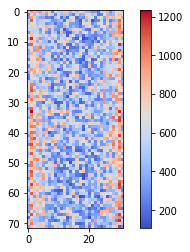

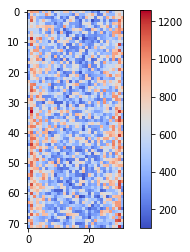

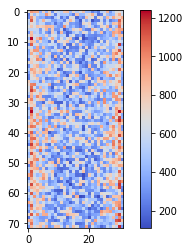

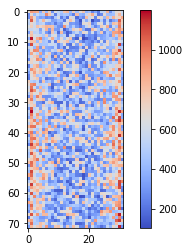

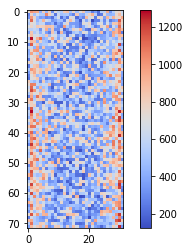

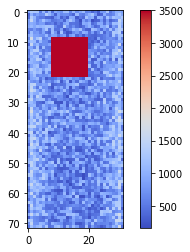

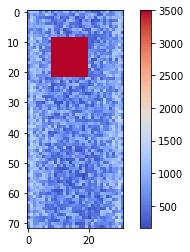

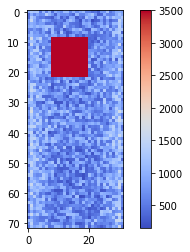

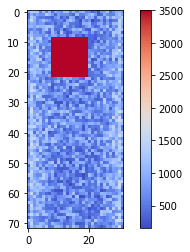

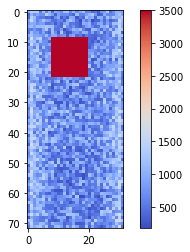

In [5]:
for i in range(10):
    im=plt.imshow(hotregion_image[0][i],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()

In [6]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape

(5974, 10, 72, 32)


In [7]:
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1
"""Nonlinear normalization and adding the padding layer of 0.5s"""
X_shape = X.shape
filler = np.ones((X_shape[0],X_shape[1],X_shape[2]+2,X_shape[3]+2))/2
for i in range(X_shape[0]):
    for j in range(X_shape[1]):
        for k in range(1,X_shape[2]+1):
            for m in range(1,X_shape[3]+1):
                val = X[i][j][k-1][m-1]
                X[i][j][k-1][m-1] = val*(1.75-(0.5/0.67)*val)
                filler[i][j][k][m] = X[i][j][k-1][m-1]
            
X = filler

In [8]:
#this is because I am only going to add the hot and dead region images

print input_images.shape
y[-1*input_images.shape[0]:]=1
#if you want it as integers leave this as it is
#if you would like it as a vector then do this
y=to_categorical(y,2)

(2987, 10, 72, 32)


In [9]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
movie_length, img_rows, img_cols = X.shape[1],X.shape[2],X.shape[3]

X shape is:  (5974, 10, 74, 34)
y shape is:  (5974, 2)


In [10]:

Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.75,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape

Xtrain, Xtest,input_shape= u.check_test_and_train_images_format_movies(Xtrain, Xtest, movie_length, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    
print input_shape

Xtrain.shape (1493, 10, 74, 34)
Xtest.shape (4481, 10, 74, 34)
ytrain.shape (1493, 2)
ytest.shape (4481, 2)
Xtrain.shape after if statement (1493, 10, 74, 34, 1)
Xtest.shape after if statement (4481, 10, 74, 34, 1)
ytrain.shape after if statement (1493, 2)
ytest.shape after if statement (4481, 2)
(10, 74, 34, 1)


# Creating the model

In [23]:
"""A Custom Loss Function"""

#### [0.1,0.9] works well (acc > 0.99) but still no movement across the diagonal

x = np.array([[0.1,0.9]])
w = K.variable(x, name='w')

def customLoss(yTrue,yPred):
    return K.sum(K.dot(w, K.transpose(K.square(yTrue - yPred))))

def custom_kullback_leibler(y_pred,y_true):
    eps = 0.0001
    results, updates = tf.scan(lambda y_true,y_pred: (y_true+eps)*(K.log(y_true+eps)-K.log(y_pred+eps)), sequences = [y_true,y_pred])
    return K.sum(K.dot(w, results), axis= - 1)

In [24]:
# this is the dummy model
from keras.layers import LSTM, ConvLSTM2D, GRU, MaxPooling3D

model = Sequential()

model.add(ConvLSTM2D(filters=5, kernel_size=(3,3), strides=(1, 1), activation='tanh', input_shape=input_shape, return_sequences=True))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(4,4,2),strides=(4,4,1)))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(2, activation='softmax'))


model.compile(loss=custom_kullback_leibler,
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])
model.summary()
plot_model(model, to_file='Supervised_model.png',)

model.save('emptymodel.hdf5')

TypeError: scan() got an unexpected keyword argument 'sequences'

In [21]:
checkpointer = ModelCheckpoint(filepath='best_nbmodel_good_hot_dead.hdf5', verbose=2, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

In [18]:
history = model.fit(Xtrain,ytrain,epochs=300
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])

Train on 1493 samples, validate on 4481 samples
Epoch 1/300
Epoch 00001: val_loss improved from inf to 13.86308, saving model to best_nbmodel_good_hot_dead.hdf5
 - 646s - loss: 15.8135 - acc: 0.5030 - val_loss: 13.8631 - val_acc: 0.4985
Epoch 2/300
Epoch 00002: val_loss did not improve
 - 647s - loss: 15.7796 - acc: 0.5044 - val_loss: 15.3842 - val_acc: 0.4985
Epoch 3/300


KeyboardInterrupt: 

In [ ]:

u.plot_loss(history, "model log loss","log")
u.plot_acc(history, "model log acc","log")

u.plot_loss(history, "model loss","linear")
u.plot_acc(history, "model acc","linear")


# Loading and Evaluation of a trained model

In [ ]:
best_model= load_model('best_nbmodel_good_hot_dead.hdf5',compile=False)

In [ ]:
ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

In [ ]:
np.all(ypredproba==ypred)
#this confirms my suspicions

In [ ]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['Good','Bad']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(ytestclass,ypredclass)


In [ ]:
plt.figure(figsize=(9,7))
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='o')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
 

# Loading and using real bad data

(257, 72, 84)



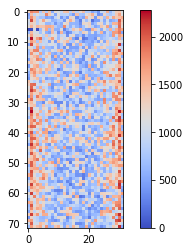

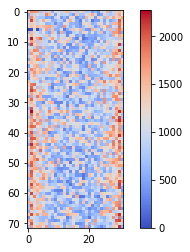

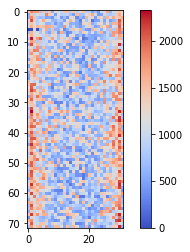

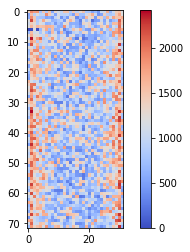

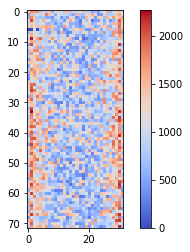

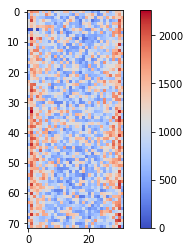

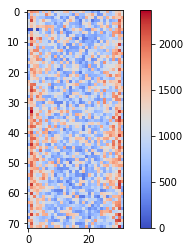

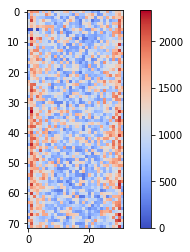

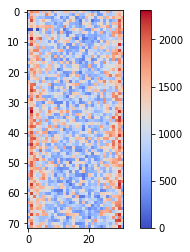

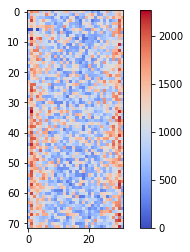

In [25]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ_run315488_corrupted.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

input_file=h5py.File(data_folder+"/"+file_name,'r+')

data_sample= np.array(input_file[group])




print data_sample.shape
bad_data_sample=data_sample[:,:,26:58]

for k in bad_data_sample[:10]:
    
    print ''
    
    im=plt.imshow(k,cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()

In [26]:
BadX=np.copy(bad_data_sample)
print BadX.shape
Bady=np.zeros((bad_data_sample.shape[0],1))

(257, 72, 32)


In [27]:
if K.image_data_format() == 'channels_first':
        BadX = BadX.reshape(BadX.shape[0], 1, img_rows, img_cols)
else:
        BadX = BadX.reshape(BadX.shape[0], img_rows, img_cols, 1)

ValueError: cannot reshape array of size 592128 into shape (257,72,84,1)

In [ ]:
ybadpredclass=best_model.predict_classes(BadX)
print ybadpredclass.shape
ybadpredclass=ybadpredclass.reshape(ybadpredclass.shape[0],1)

In [ ]:
print ybadpredclass[:5].shape

In [ ]:
print ybadpredclass

In [ ]:
bconfm= metrics.confusion_matrix(Bady,ybadpredclass)

plotlabels=['good','bad']
u.plot_confusion_matrix(bconfm,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(Bady,ybadpredclass)
